In [1]:
# ref : https://www.kaggle.com/uciml/pima-indians-diabetes-database?select=diabetes.csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score

# 1. 데이터 사전 탐색(EDA)

In [3]:
df = pd.read_csv('diabetes.csv')

In [4]:
df.shape

(768, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


* Pregnancies : 임신횟수
* Glucose : 포도당수치
* BloodPressure : 혈압
* SkinThickness : 피하지방
* Insulin : 인슐린
* BMI : 체질량지수
* DiabetesPedigreeFunction : 유전적(가족력)
* Age : 나이
* Outcome : 당뇨여부 1(당뇨) / 0(정상)

## 무조건 점수부터 보자 (결측없다, 수치형피쳐)

In [37]:
def myfit(df_X, df_y, model, imp=0, tsize=0.2):
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=tsize, random_state=36,  shuffle=False)
    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accuracy = accuracy_score(pred ,  y_test)
    precision = precision_score(pred ,  y_test)
    recall = recall_score(pred ,  y_test)
    f1 = f1_score(pred ,  y_test)
    print("Accuracy:{:.6f}  precision:{:.6f}, recall:{:.6f}, f1:{:.6f}".format(accuracy, precision, recall, f1))
    
#     if imp==1:
#         imp_df = pd.DataFrame({"featuer" : X_train.columns, "importance" : model.feature_importances_})
#         imp_df = imp_df.sort_values('importance', ascending=False).T
#         print(imp_df)

In [8]:
rf = RandomForestClassifier()
df_y = df["Outcome"]
df_X = df.drop("Outcome", axis=1)
print(df_X.shape, df_y.shape)

(768, 8) (768,)


In [9]:
myfit(df_X, df_y, rf, imp=1)   # 0.720779

Accuracy : 0.720779
                   1         5         7                         6  \
featuer      Glucose       BMI       Age  DiabetesPedigreeFunction   
importance  0.252622  0.178928  0.129908                  0.121123   

                        2            0         4              3  
featuer     BloodPressure  Pregnancies   Insulin  SkinThickness  
importance       0.089277     0.078823  0.077974       0.071345  


## 불균형 확인

In [10]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

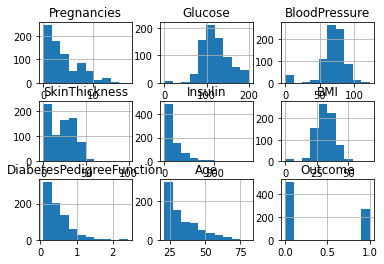

In [11]:
df.hist()
plt.show()

### 0데이터 확인

In [12]:
nan_dict = {"CNT":df.isin([0]).sum(),
            "RATE": df.isin([0]).sum()/df.shape[0] *100
}
nan_df = pd.DataFrame(nan_dict)
print(nan_df[nan_df["RATE"]>0].sort_values("CNT", ascending=False))


               CNT       RATE
Outcome        500  65.104167
Insulin        374  48.697917
SkinThickness  227  29.557292
Pregnancies    111  14.453125
BloodPressure   35   4.557292
BMI             11   1.432292
Glucose          5   0.651042


* Insulin        374  48.697917
* SkinThickness  227  29.557292  --??
* BloodPressure   35   4.557292
* BMI             11   1.432292
* Glucose          5   0.651042

### 각 피쳐당 0값을 평균값으로 대체

In [13]:
zero_feature = ["Insulin","SkinThickness","BloodPressure","BMI","Glucose"]
zero_mean = df[zero_feature].mean()
df[zero_feature] = df[zero_feature].replace(0, zero_mean)

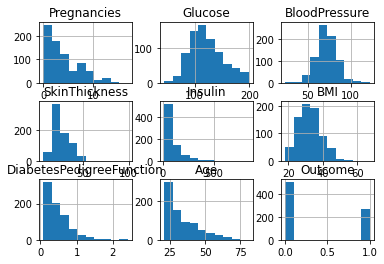

In [14]:
df.hist()
plt.show()

In [15]:
df.head()  

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


In [16]:
## 스케일링 : 정규화

### 방법1) df_X.splite -->  train.fit_transform  --> test.transform

In [31]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
std_scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=36,  shuffle=False)
std_scaler = StandardScaler()
X_train_scaler = std_scaler.fit_transform(X_train)  
X_test_scaler  = std_scaler.transform(X_test)    #---------------------스케일링 1/10 적용

rf.fit(X_train_scaler, y_train)
pred = rf.predict(X_test_scaler)
df_score = accuracy_score(pred ,  y_test)
print(f'StandardScaler:  {df_score:.4f}')  # 0.766234

StandardScaler:  0.7468


### 방법2)  df_X.fit_transform --> train_test_split 

In [18]:
std_scaler = StandardScaler()
rbs_scaler = RobustScaler()
mmx_scaler = MinMaxScaler()
scaler_list = [("StandardScaler",std_scaler), ("RobustScaler",rbs_scaler), ("MinMaxScaler",mmx_scaler)]

for scaler in scaler_list:
    df_X_scaler = scaler[1].fit_transform(df_X)   
    X_train, X_test, y_train, y_test = train_test_split(df_X_scaler, df_y, test_size=0.2, random_state=36,  shuffle=False)
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    df_score = accuracy_score(pred ,  y_test)
    print(f'{scaler[0]:s}:  {df_score:.4f}')


StandardScaler:  0.7403
RobustScaler:  0.7532
MinMaxScaler:  0.7532


In [38]:
myfit(df_X_scaler, df_y, rf, imp=1) 

Accuracy:0.759740  precision:0.545455, recall:0.714286, f1:0.618557


In [19]:
# myfit(train_X_scaler, train_y, rf, imp=1)

In [28]:
# plt.hist(df_X_scaler)